# Pretrained ImageNet Classifier with fastai v1

- Author: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou)
- Date: January 2019
- Source: https://discuss.pytorch.org/t/pretrained-resnet-constant-output/2760

## Objective

The objective here is to use [fastai v1](https://docs.fast.ai/index.html) instead of Pytorch code in order to classify images into 1000 classes by using an ImageNet winner model.

## Initialisation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.widgets import *

In [3]:
from io import BytesIO

In [4]:
import fastai
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.42
cuda: True


In [5]:
path = Config.data_path()
os.makedirs(path/'imagenet', exist_ok=True)
path = path/'imagenet'

## Get the ImageNet classes

**Option 1**: download json file from https://discuss.pytorch.org/t/imagenet-classes/4923/3

In [ ]:
import urllib.request, json

# Distant json file
# url_json = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
# with urllib.request.urlopen(url_json) as url:
#     class_idx = json.loads(url.read().decode())
    
# local json file 
json_file = json.load(open(path/'imagenet_class_index.json'))

classes = [json_file[str(k)][1] for k in range(len(json_file))]

**Option 2**: download txt file from the [Kaggle ImageNet Object Localization Challenge](https://www.kaggle.com/c/imagenet-object-localization-challenge/data)

In [6]:
# Source:  
# Accept rules and Download file from )
txt_file = path/'LOC_synset_mapping.txt'
f = open(txt_file).read().split("\n")

classes = [f[i].split(' ', 1)[1] for i in range(len(f))]

In [7]:
classes[:10]

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus']

In [8]:
# Keep the first label by class
classes = [classes[i].split(',', 1)[0] for i in range(len(classes))]

In [9]:
classes[:10]

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

## Model

Let's use resnet34.

In [10]:
# Get weights of the model and add nn.LogSoftmax(dim=1) to the end
model_name = 'resnet34'
model = models.resnet34(pretrained=True)
model = nn.Sequential(model, nn.LogSoftmax(dim=1))

In [11]:
# Transformation to apply to image before prediction (center crop)
# tfms = get_transforms() is possible too
tfms = [ [], [crop_pad()] ]

In [12]:
# Get an empty databunch with the ImageNet classes
# WARNING single_from_classes is deprecated (https://docs.fast.ai/vision.data.html#ImageDataBunch.single_from_classes)
data = ImageDataBunch.single_from_classes(path, classes, tfms=tfms, size=224).normalize(imagenet_stats)

In [13]:
# Get the learner of the model
learn = Learner(data, model)

In [14]:
# Save the learner
learn.export(f'{model_name}.pkl')

## Data to classify

In [15]:
# List of images to classify
images = [
          ('cat', 'https://www.readersdigest.ca/wp-content/uploads/sites/14/2011/01/4-ways-cheer-up-depressed-cat.jpg'),
          ('dog', 'https://c.photoshelter.com/img-get/I0000q_DdkyvP6Xo/s/900/900/Pomeranian-Dog-with-Ball.jpg'),
          ('wine', 'https://www.thetimes.co.uk/imageserver/image/methode%2Fsundaytimes%2Fprod%2Fweb%2Fbin%2F5e7dc0d2-9b24-11e8-9837-8c5d4fba4ce3.jpg?crop=2667%2C1500%2C0%2C0&resize=685')
         ]

## Get prediction

In [16]:
model_name = 'resnet34'

In [17]:
# Put teh defaults device to CPU
defaults.device = torch.device('cpu')

In [18]:
# Import the learner
# Tutorial online at https://docs.fast.ai/tutorial.inference.html
learn = load_learner(path, f'{model_name}.pkl')

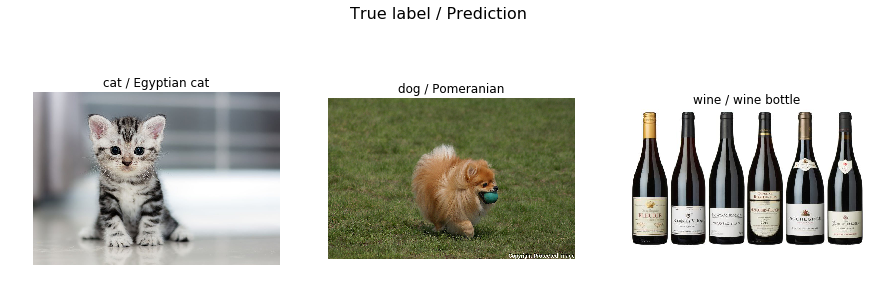

In [19]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
fig.suptitle('True label / Prediction', fontsize=16)

for i, image in enumerate(images):
    
    # Get image
    class_name, img_url = image[0], image[1]
    response = requests.get(img_url)
    img = open_image(BytesIO(response.content))

    # Get prediction
    cat, indice, preds = learn.predict(img)
    
    # Display images with True label / Prediction
    img.show(ax=ax[i], title=f'{class_name} / {cat}')